In [78]:
import numpy as np
from numpy.linalg import norm, inv, matrix_rank
from scipy.linalg import svd
import matplotlib.pyplot as plt

np.random.seed(42)

### ADMM - Compressed Sensing

In [79]:
m = 50
n = 25

A = np.random.randint(1, 10, (m, n))
b = np.random.randint(1, 10, (m, 1))

In [80]:
def soft_threshold(x, lam):
  return np.sign(x) * np.maximum(np.abs(x) - lam, 0)

def card(x, tol = 1e-1):
  return np.sum(np.abs(x).flatten() > tol)

In [81]:
def admm_vector(A, b, mu, lambda_=1, max_iter=1000, tol=1e-4):

    m, n= A.shape

    # Initialize variables
    x = np.zeros(n) 
    y = np.zeros(n) 
    z = np.zeros(n)

    # Track objective values
    objective_values = []
    cards = []

    f = lambda x,y: mu*norm(y, 1) + norm(A@x - b, 2)**2/2

    # ADMM iterations
    for iter in range(max_iter):
        x = np.linalg.solve(A.T @ A + lambda_ * np.eye(n), A.T @ b + lambda_ * y - z)
        y = np.sign(x + 1/lambda_*z) * np.maximum(np.abs(x + 1/lambda_*z) - mu / lambda_, 0)
        z = z + lambda_*(x - y)

        objective_values.append(f(x, y))
        cards.append(card(x))

        # Check convergence
        if iter > 0 and abs(objective_values[-1] - objective_values[-2]) / objective_values[-2] < tol:
            print(f"Converged in {iter+1} iterations.")
            break
    else:
        print("Reached maximum iterations without full convergence.")

    # Plot objective values
    plt.figure()
    plt.plot(objective_values, label=r'$f(x)$')
    plt.plot(cards, label=r'$\|x\|_0$')
    plt.xlabel('Iteration')
    plt.legend()
    plt.grid()
    plt.show()

    return x

Converged in 30 iterations.


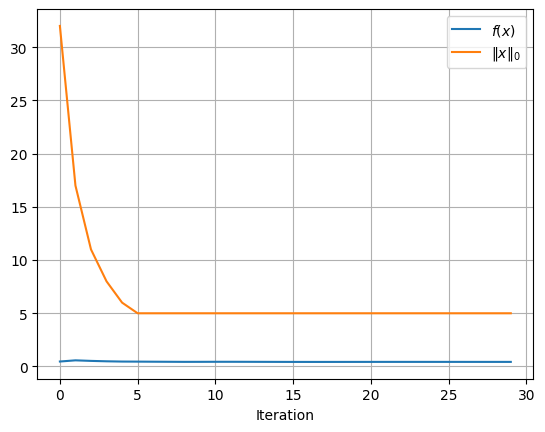

In [82]:
m, n = 30, 50
A = np.random.randn(m, n)
x_true = np.zeros(n)
x_true[:5] = np.random.randn(5)
b = A @ x_true

mu = 0.1      
x_est = admm_vector(A, b, mu)

### ADMM - Minimal rank

In [83]:
def chosen_data(X, Omega):
    return X*Omega
def unchosen_data(X, Omega):
    return X*(1 - Omega)

def nonnegative_projection(X):
    return np.maximum(X, 0)

def nuclear_norm(M):
    return np.sum(np.linalg.svd(M, compute_uv=False))

def diag(diagonal, m, n):
    matrix = np.zeros((m, n))
    diag_length = min(len(diagonal), m, n)
    np.fill_diagonal(matrix[:diag_length, :diag_length], diagonal[:diag_length])
    return matrix

def prox_nuclear_norm(X, lam):
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    sigma_thresh = np.maximum(S - lam, 0)
    return (U * sigma_thresh) @ Vt

In [84]:
def admm_matrix(B, Omega, mu, lambda_, max_iter, tol):

    m, n = B.shape

    X = np.zeros((m, n))
    Y = np.zeros((m, n))
    Z = np.zeros((m, n))

    f = lambda X, Y: mu * nuclear_norm(Y) + 0.5 * np.linalg.norm(chosen_data(X, Omega) - chosen_data(B, Omega))**2
    
    objective_values = []
    ranks = []

    compute_X = lambda Y, Z: nonnegative_projection((1 / (1 + lambda_)) * chosen_data(B + lambda_ * Y - Z, Omega) + \
                   nonnegative_projection(unchosen_data(Y - (1 / lambda_) * Z, Omega)))
    compute_Y = lambda X, Z: prox_nuclear_norm(X + (1/lambda_)*Z, mu/lambda_)

    for k in range(max_iter):
        X = compute_X(Y, Z)
        Y = compute_Y(X, Z)
        Z = Z + lambda_ * (X - Y)

        objective_values.append(f(X, Y))
        ranks.append(matrix_rank(X))

        if k > 0 and abs(objective_values[-1] - objective_values[-2]) / objective_values[-2] < tol:
            print(f"Converged in {k+1} iterations.")
            break
    else:
        print("Reached maximum iterations without full convergence.")

    plt.figure()
    plt.plot(objective_values, label=r'$f(X,Y)$')
    plt.plot(ranks, label=r'$\mathrm{rank}(X)$')
    plt.xlabel('Iteration')
    plt.legend()
    plt.grid()
    plt.show()

    return X


Converged in 72 iterations.


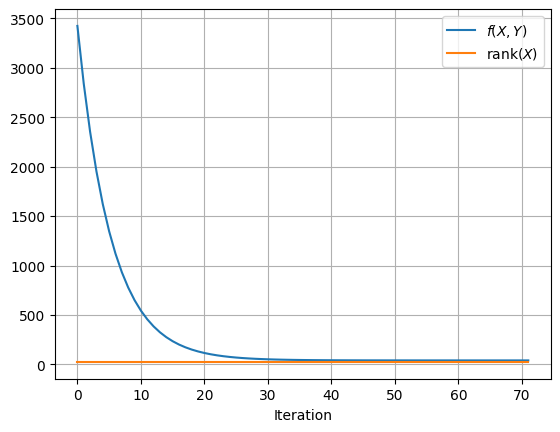

In [85]:
m = 50
n = 25
sparsity = 0.2

B = np.random.randint(0, 10, (m, n))*(np.random.rand(m, n) < sparsity)
Omega = B > 0  # Take all available data

mu = 0.1 
lambda_ = 10

X = admm_matrix(B, Omega, mu, lambda_, max_iter=10000, tol=1e-4)

The rank does not change, while the derived objective becomes better.